In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t

In [8]:
class Zonotope:
    def __init__(self, centre, generators):
        self.centre = np.array(centre).reshape(-1)         # shape (n,)
        self.generators = np.atleast_2d(generators)        # shape (n, m)
        if self.generators.shape[0] != self.centre.shape[0]:
            raise ValueError("Generators must have same dimension as centre")
        self.n = self.centre.shape[0]   # dimension
        self.m = self.generators.shape[1]  # number of generators

    def minkowski_sum(self, other):
        new_centre = self.centre + other.centre
        new_generators = np.hstack((self.generators, other.generators))
        return Zonotope(new_centre, new_generators)
    
    # Outer Approx. of the zonotope - Affine Arithmetic Paper
    def output_interval(self):
        radius = np.sum(np.abs(self.generators), axis=1)  # sum across generators
        lower = self.centre - radius
        upper = self.centre + radius
        return lower, upper

    def affine_map(self, A, b=None):
        new_centre = A @ self.centre + (b if b is not None else 0)
        new_generators = A @ self.generators 
        return Zonotope(new_centre, new_generators)

### Data

In [9]:
df = pd.read_csv('Data/AmesHousing.csv')
df.head()

y = df['SalePrice'].values

Delta = np.abs(np.random.normal(15000, 10000, len(df)))
b = np.random.uniform(-1, 1, size=len(df))

m = y + b * Delta

df['SALEPRICE_LOWER'] = m - Delta
df['SALEPRICE_UPPER'] = m + Delta


df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,SALEPRICE_LOWER,SALEPRICE_UPPER
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,5,2010,WD,Normal,215000,186767.433044,219442.093657
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,MnPrv,NaN,0,6,2010,WD,Normal,105000,104943.715517,105049.515582
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,Gar2,12500,6,2010,WD,Normal,172000,131683.381223,188631.828254
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,4,2010,WD,Normal,244000,243806.114376,255133.446088
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,MnPrv,NaN,0,3,2010,WD,Normal,189900,182059.358093,190516.213376


### Regression

In [10]:
def prediction_intervals(design, grid, inverse, residuals, zono_lower, zono_upper, alpha=0.05):
    n, p = design.shape
    t_val = t.ppf(1 - alpha / 2, df=n - p)

    sigma2 = np.sum(residuals**2) / (n - p)
    sigma = np.sqrt(sigma2)

    quad_form = np.sum((grid @ inverse) * grid, axis=1)
    SE_conf = sigma * np.sqrt(quad_form)
    SE_pred = sigma * np.sqrt(1.0 + quad_form)
    
    y_lower_PI = zono_lower - t_val * SE_pred
    y_upper_PI = zono_upper + t_val * SE_pred
    
    y_lower_CB = zono_lower - t_val * SE_conf
    y_upper_CB = zono_upper + t_val * SE_conf

    return (
        y_lower_CB,
        y_upper_CB,
        y_lower_PI,
        y_upper_PI
    )

def polynomial_basis(X, degree=5):
    X = np.asarray(X).flatten()
    X_scaled = (X - X.min()) / (X.max() - X.min())
    Phi = np.column_stack([X_scaled**i for i in range(degree+1)])
    return Phi

def nonlinear_zonotope_bounds(
    X,
    y_lower,
    y_upper,
    x_grid=None,
    degree=10,
    alpha=0.05
):
    X = np.asarray(X).flatten()
    y_lower = np.asarray(y_lower).flatten()
    y_upper = np.asarray(y_upper).flatten()

    centre_y = 0.5 * (y_lower + y_upper)
    radii_y = 0.5 * (y_upper - y_lower)

    Phi = polynomial_basis(X, degree)

    PhiTPhi = Phi.T @ Phi
    PhiT_inv = np.linalg.inv(PhiTPhi)
    M = PhiT_inv @ Phi.T

    Y_zono = Zonotope(centre_y, np.diag(radii_y))
    Beta_zono = Y_zono.affine_map(M)

    # Residual variance (centre model)
    beta_hat = M @ centre_y
    residuals = centre_y - Phi @ beta_hat

    if x_grid is None:
        return Beta_zono


    Phi_grid = polynomial_basis(x_grid, degree)
    Yhat_zono = Beta_zono.affine_map(Phi_grid)
    y_lower_zono, y_upper_zono = Yhat_zono.output_interval()

    y_lower_CB, y_upper_CB, y_lower_PI, y_upper_PI = prediction_intervals(design=Phi, grid=Phi_grid, inverse=PhiT_inv, residuals=residuals, zono_lower=y_lower_zono, zono_upper=y_upper_zono, alpha=alpha)

    return (
        Beta_zono,
        Yhat_zono,
        y_lower_zono,
        y_upper_zono,
        y_lower_CB,
        y_upper_CB,
        y_lower_PI,
        y_upper_PI
    )

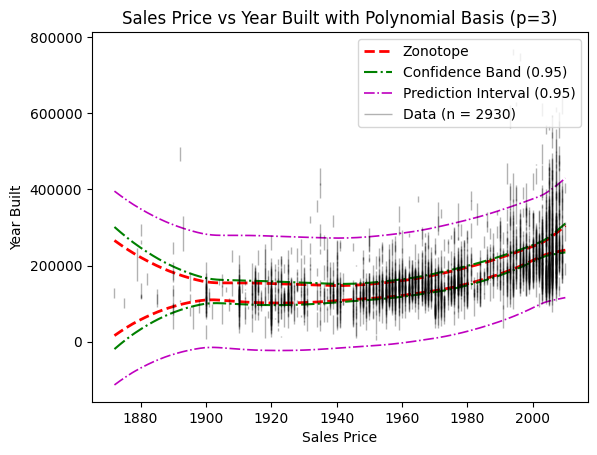

In [12]:
x_grid = np.linspace(df['Year Built'].min(), 
                     df['Year Built'].max(), 
                     len(df))


_, y_pred, y_min, y_max, y_lower_CB, y_upper_CB, y_lower_PI, y_upper_PI = nonlinear_zonotope_bounds(df['Year Built'].values, df['SALEPRICE_LOWER'].values, df['SALEPRICE_UPPER'].values, x_grid, degree=3)




plt.plot(x_grid, y_min, '--r', label='Zonotope', linewidth=2)
plt.plot(x_grid, y_max, '--r', linewidth=2)

# Confidence bands
plt.plot(x_grid, y_lower_CB, '-.g', label='Confidence Band (0.95)', linewidth=1.5)
plt.plot(x_grid, y_upper_CB, '-.g', linewidth=1.5)

# Prediction intervals
plt.plot(x_grid, y_lower_PI, '-.m', label='Prediction Interval (0.95)', linewidth=1.2)
plt.plot(x_grid, y_upper_PI, '-.m', linewidth=1.2)


n_samples = len(df)
for i in range(len(df)):
    label = f'Data (n = {n_samples})' if i == 0 else None
    plt.vlines(x=df['Year Built'].iloc[i], 
               ymin=df['SALEPRICE_LOWER'].iloc[i], 
               ymax=df['SALEPRICE_UPPER'].iloc[i],
               colors='black', alpha=0.3, linewidth=1, label=label)
    
plt.legend()
plt.title('Sales Price vs Year Built with Polynomial Basis (p=3)')
plt.xlabel('Sales Price')
plt.ylabel('Year Built')
plt.show()